In [ ]:
pip install transformers tiktoken

In [ ]:
import os
import json
import regex as re
import requests
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import pickle
import math
import time
from collections import defaultdict
import tiktoken

# 0) Generative Pre-trained Transformer (GPT)

GPT model only has decoder block.While encoder block only generate the output with similar length as input, decoder is generative in nature. The encoder is not needed because the model does not need to learn the representation of the input sequence.

It produces estimates for the probability of the next word as outputs but it is auto-regressive as each token in the sentence has the context of the previous words. Thus GPT-2 works one token at a time. BERT, by contrast, is not auto-regressive. It uses the entire surrounding context all-at-once.

# 1) Tokenization (Byte Pair Encoding)

The GPT-2 and RoBERTa tokenizers (which are pretty similar) have a clever way to deal with this: they don’t look at words as being written with Unicode characters, but with bytes. This way the base vocabulary has a small size (256), but every character you can think of will still be included and not end up being converted to the unknown token. This trick is called byte-level BPE.

[Description](https://huggingface.co/course/chapter6/5?fw=pt) | [Code](https://github.com/karpathy/minGPT/blob/master/mingpt/bpe.py)

## 1.1 BPE from Scratch

Unlike WordPiece, it's impossible to get an unknown character when using byte-level BPE

In [ ]:
from transformers import AutoTokenizer
from collections import defaultdict

tokenizer = AutoTokenizer.from_pretrained("gpt2")

corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
### pre-tokenization ###
word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

### split into single alphabet ###
alphabet = []
for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()
print(alphabet)

# split each word into subword
splits = {word: [c for c in word] for word in word_freqs.keys()}
print(splits)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})
[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']
{'This': ['T', 'h', 'i', 's'], 'Ġis': ['Ġ', 'i', 's'], 'Ġthe': ['Ġ', 't', 'h', 'e'], 'ĠHugging': ['Ġ', 'H', 'u', 'g', 'g', 'i', 'n', 'g'], 'ĠFace': ['Ġ', 'F', 'a', 'c', 'e'], 'ĠCourse': ['Ġ', 'C', 'o', 'u', 'r', 's', 'e'], '.': ['.'], 'Ġchapter': ['Ġ', 'c', 'h', 'a', 'p', 't', 'e', 'r'], 'Ġabout': ['Ġ', 'a', 'b', 'o', 'u', 't'], 'Ġtokenization': ['Ġ', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n'], 'Ġsection':

In [ ]:
### compute pair frequency ###
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

pair_freqs = compute_pair_freqs(splits)
print(pair_freqs)

defaultdict(<class 'int'>, {('T', 'h'): 3, ('h', 'i'): 3, ('i', 's'): 5, ('Ġ', 'i'): 2, ('Ġ', 't'): 7, ('t', 'h'): 3, ('h', 'e'): 2, ('Ġ', 'H'): 1, ('H', 'u'): 1, ('u', 'g'): 1, ('g', 'g'): 1, ('g', 'i'): 1, ('i', 'n'): 2, ('n', 'g'): 1, ('Ġ', 'F'): 1, ('F', 'a'): 1, ('a', 'c'): 1, ('c', 'e'): 1, ('Ġ', 'C'): 1, ('C', 'o'): 1, ('o', 'u'): 3, ('u', 'r'): 1, ('r', 's'): 2, ('s', 'e'): 3, ('Ġ', 'c'): 1, ('c', 'h'): 1, ('h', 'a'): 1, ('a', 'p'): 1, ('p', 't'): 1, ('t', 'e'): 2, ('e', 'r'): 5, ('Ġ', 'a'): 5, ('a', 'b'): 2, ('b', 'o'): 1, ('u', 't'): 1, ('t', 'o'): 4, ('o', 'k'): 3, ('k', 'e'): 3, ('e', 'n'): 4, ('n', 'i'): 2, ('i', 'z'): 2, ('z', 'a'): 1, ('a', 't'): 2, ('t', 'i'): 2, ('i', 'o'): 2, ('o', 'n'): 2, ('Ġ', 's'): 3, ('e', 'c'): 1, ('c', 't'): 1, ('s', 'h'): 1, ('h', 'o'): 2, ('o', 'w'): 2, ('w', 's'): 1, ('e', 'v'): 1, ('v', 'e'): 1, ('r', 'a'): 3, ('a', 'l'): 2, ('z', 'e'): 1, ('l', 'g'): 1, ('g', 'o'): 1, ('o', 'r'): 1, ('r', 'i'): 1, ('i', 't'): 1, ('h', 'm'): 1, ('m', 's'): 

In [ ]:
### finding best pair ###
best_pair = ""
max_freq = None
for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

### add special token, merge best pair and append ###
vocab = ["<|endoftext|>"] + alphabet.copy()
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

('Ġ', 't') 7


In [ ]:
### merge pair ###
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [ ]:
### loop and merge ###
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

### unlike wordpiece, BPE looks at merges instead of vocab ###
print(merges)
print(vocab)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}
['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se', 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']


In [ ]:
### tokenize word ###
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

# 2) Dataset

In [ ]:
# download the tiny shakespeare dataset
data_dir = os.path.join('data', 'tinyshakespeare')
input_file_path = os.path.join(data_dir, 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    os.makedirs(data_dir)
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode with tiktoken gpt2 bpe
enc = tiktoken.get_encoding("gpt2")
train_ids = enc.encode_ordinary(train_data)
val_ids = enc.encode_ordinary(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(data_dir, 'train.bin'))
val_ids.tofile(os.path.join(data_dir, 'val.bin'))

train has 301,966 tokens
val has 36,059 tokens


In [ ]:
class GPTConfig:
    def __init__(self, vocab_size, **kwargs):
        self.vocab_size = vocab_size
        for key, value in kwargs.items():
            setattr(self, key, value)

class CustomConfig(GPTConfig):
    # model
    n_layer = 8
    n_head = 8
    n_embd = 256
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1
    dropout = 0.1
    compile = True

    # data
    device = 'cuda'
    num_workers = 0

    # optimizer parameters
    max_iters = 2e4
    batch_size = 4
    block_size = 64
    learning_rate = 6e-4
    betas = (0.9, 0.95)
    weight_decay = 1e-1
    grad_norm_clip = 1.0

# config
vocab_size = len(train_ids)
config = CustomConfig(vocab_size=vocab_size)

In [ ]:
# read data from .bin
data_dir = os.path.join('data', 'tinyshakespeare')
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')

class ShakespeareDataset(Dataset):
    def __init__(self, split, block_size=128, device_type='cuda'):
        assert split in {'train', 'test'}
        self.split = split
        self.block_size = block_size
        self.device_type = device_type
        self.data = train_data if split == 'train' else val_data

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # ix = torch.randint(len(data) - block_size, (batch_size,))
        # x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
        # y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
        x = torch.from_numpy(self.data[idx : idx + self.block_size].astype(np.int64))
        y = torch.from_numpy(self.data[idx + 1 : idx + 1 + self.block_size].astype(np.int64))

        if self.device_type == 'cuda':
            # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
            x, y = x.pin_memory().to('cuda', non_blocking=True), y.pin_memory().to('cuda', non_blocking=True)
        else:
            x, y = x.to('cpu'), y.to('cpu')
        return x, y

train_dataset = ShakespeareDataset('train', config.block_size, config.device)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers, drop_last=False)
test_dataset = ShakespeareDataset('test', config.block_size, config.device)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=config.num_workers, drop_last=False)
sample_data = next(iter(train_loader))
x, y = sample_data
print("x:", x.size())
print("y:", y.size())

x: torch.Size([4, 64])
y: torch.Size([4, 64])


# 3) Modeling

In [ ]:
class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It's important in decoder block to have diagonal mask
    It is also possible to use torch.nn.MultiheadAttention.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.dropout = config.dropout
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # flash attention make GPU go faster but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            # use register_buffer when: you want a stateful part of your model that is not a parameter
            # but you want it in your state_dict
            self.register_buffer(
                "mask",
                torch.tril(torch.ones(config.block_size, config.block_size)
            ).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        # batch_size, seq_len, emb_dim
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # (b, seq_len, emb_dim) --> (b, seq_len, emb_dim * 3) --> (b, seq_len, emb_dim)
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (b, h, seq_len, d_k)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (b, h, seq_len, d_k)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (b, h, seq_len, d_k)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True
            )
        else:
            # (b, h, seq_len, d_k) matmul (b, h, d_k, seq_len) --> (b, h, seq_len, seq_len)
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            # diagonal mask
            # fill 0 mask with super small number so it wont affect the softmax weight
            # (batch_size, h, seq_len, seq_len)
            att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)

            # (b, h, seq_len, seq_len) matmul (b, h, seq_len, d_k) --> (b, h, seq_len, d_k)
            y = att @ v

        # (b, h, seq_len, d_k) --> (b, seq_len, h, d_k) --> (b, seq_len, d_model)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y


class Block(nn.Module):
    """ GPT only contain decode block"""

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)

        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            act     = NewGELU(),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))

    def forward(self, x):

        # (batch_size, seq_len, emb_dim)
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

### testing
wte = nn.Embedding(config.vocab_size, config.n_embd).to(config.device)
block = Block(config).to(config.device)

tok_emb = wte(x)
print('Token Embedding Size:', tok_emb.size())

block_out = block(tok_emb)
print('Block Output Size:', block_out.size())

Token Embedding Size: torch.Size([4, 64, 256])
Block Output Size: torch.Size([4, 64, 256])


In [ ]:
class GPT(nn.Module):
    """ GPT Language Model """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        self.positional_encoding = self._get_positional_encoding(config.block_size, config.n_embd)
        self.transformer = nn.ModuleDict(dict(
            # wte = nn.Embedding(config.vocab_size, config.n_embd),
            # wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def _get_positional_encoding(self, max_seq_len, embed_size):
        positional_encoding = torch.zeros(max_seq_len, embed_size)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * -(math.log(10000.0) / embed_size))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

    def configure_optimizers(self, train_config):

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        tok_emb = self.transformer.wte(idx) # (b, t, n_embd)
        pos_emb = self.positional_encoding[:t, :].unsqueeze(0) # (1, t, n_embd)

        # positional token, shape (1, t)
        # pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
        # pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)

        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)
        # (b, t, n_embd) -- > # (b, t, vocab_size)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        # -1 at output will be ignored
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b, t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)

            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            logits = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

            # optionally crop the logits to only the top k options
            if top_k is not None:
                # from [0.2769, 0.1019, 0.3351, 0.1967, 0.0882] --> [0.452, 0.547]
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')

            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)

            if do_sample:
                # select from [0.1, 0.2, 0.3, 0.2, 0.2] --> [2, 4] (if num_samples=2)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # take the top probs index
                _, idx_next = torch.topk(probs, k=1, dim=-1)

            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

### testing
wte = nn.Embedding(config.vocab_size, config.n_embd).to(config.device)
model = GPT(config).to(config.device)
model = torch.compile(model)

# sample dataset from data loader
logits, loss = model.forward(x, y)
print('logits: ', logits.size())
print('loss: ', loss)

number of parameters: 83.64M


[2023-04-22 02:12:32,380] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


logits:  torch.Size([4, 64, 301966])
loss:  tensor(12.6203, device='cuda:0', grad_fn=<CompiledFunctionBackward>)




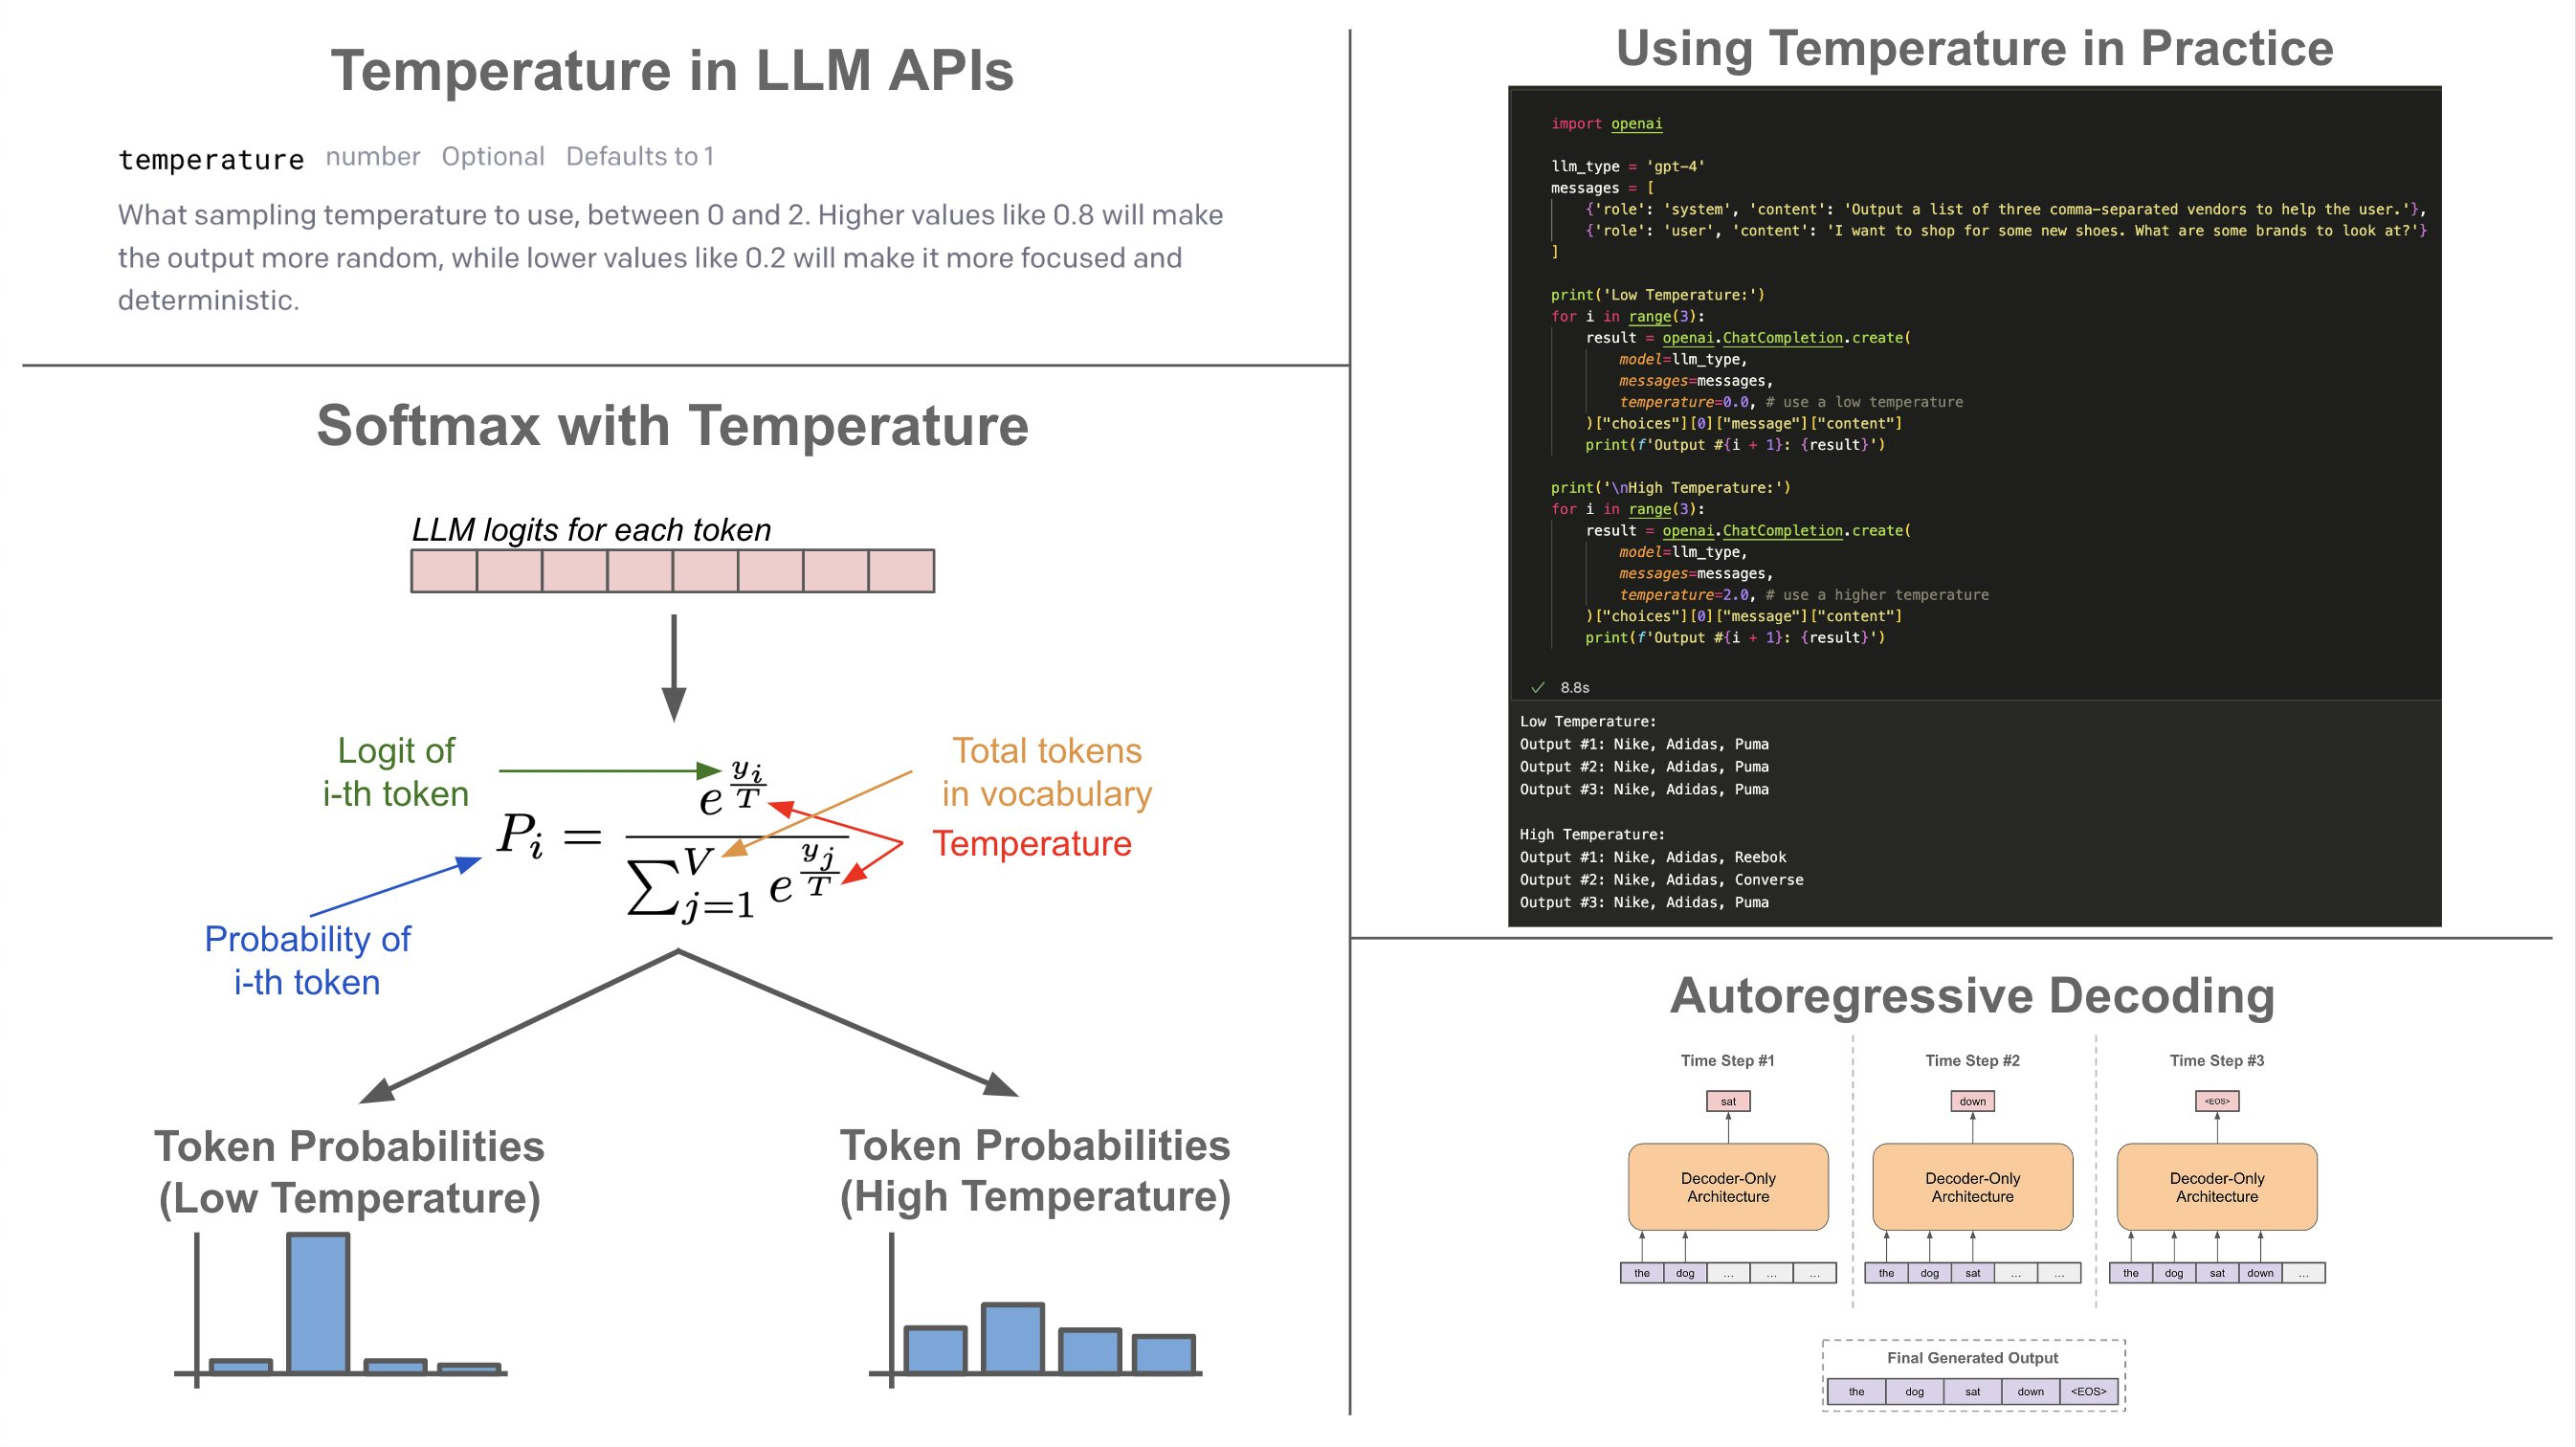


# 4) Training

In [ ]:
class Trainer:

    def __init__(self, config, model, train_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.callbacks = defaultdict(list)
        self.device = config.device
        self.model = self.model.to(self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config

        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)

        # setup the dataloader
        train_loader = DataLoader(
            self.train_dataset,
            sampler=torch.utils.data.RandomSampler(self.train_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            # pin_memory=True,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
        )

        model.train()
        self.iter_num = 0
        self.iter_time = time.time()
        data_iter = iter(train_loader)
        while True:

            # fetch the next batch (x, y) and re-init iterator if needed
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)
            batch = [t.to(self.device) for t in batch]
            x, y = batch

            # forward the model
            logits, self.loss = model(x, y)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()

            self.trigger_callbacks('on_batch_end')
            self.iter_num += 1
            tnow = time.time()
            self.iter_dt = tnow - self.iter_time
            self.iter_time = tnow

            # termination conditions
            if config.max_iters is not None and self.iter_num >= config.max_iters:
                break

model = GPT(config)
trainer = Trainer(config, model, train_dataset)
trainer = Trainer(config, model, train_dataset)

def batch_end_callback(trainer):
    if trainer.iter_num % 500 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

number of parameters: 83.64M
iter_dt 0.00ms; iter 0: train loss 12.63450
iter_dt 107.20ms; iter 500: train loss 4.48716
iter_dt 105.59ms; iter 1000: train loss 4.52789
iter_dt 108.12ms; iter 1500: train loss 4.98708
iter_dt 110.25ms; iter 2000: train loss 4.63459
iter_dt 107.60ms; iter 2500: train loss 4.00061
iter_dt 107.23ms; iter 3000: train loss 4.97294
iter_dt 108.26ms; iter 3500: train loss 5.00927
iter_dt 107.98ms; iter 4000: train loss 4.54547
iter_dt 111.64ms; iter 4500: train loss 4.49295
iter_dt 111.27ms; iter 5000: train loss 4.24072
iter_dt 107.57ms; iter 5500: train loss 4.49713
iter_dt 108.68ms; iter 6000: train loss 4.44291
iter_dt 111.30ms; iter 6500: train loss 5.33070
iter_dt 109.34ms; iter 7000: train loss 3.61869
iter_dt 107.99ms; iter 7500: train loss 4.67334
iter_dt 112.82ms; iter 8000: train loss 3.57174
iter_dt 107.69ms; iter 8500: train loss 3.86336
iter_dt 109.40ms; iter 9000: train loss 3.27506
iter_dt 109.84ms; iter 9500: train loss 4.14696
iter_dt 108.70ms

In [ ]:
text = 'Lord:\nRise! My people, conquer the north!'
sample_ids = torch.Tensor(enc.encode_ordinary(text)).long()
sample_ids = torch.unsqueeze(sample_ids, 0).to(config.device)
result = model.generate(sample_ids, max_new_tokens=50, temperature=1, do_sample=False, top_k=None)
print(enc.decode(result.detach().cpu().tolist()[0]))

Lord:
Rise! My people, conquer the north!
And, in the same blood of death,
Is my poor heart-blood, like a very heart,
To see his head in the same fair king's face.

GLOUCESTER:
I'll have his uncle
